# Correcting Marks for Examiner Variance


<br>
<br>

**Problem Statement**

Suppose we have 4 examiners each grading an exclusive group of 250 candidates (1,000 total candidates). A candidate is only graded by a single examner (no ovelaps) and is given a mark between 0 and 16. How do we account for differences in examiner quality? 

<br>

**Suggestion**

The following is a suggested method that consists of re-scaling each candidate's $z$-score, obtained by characterizing the expected mark and standard deviation of marks given by each examine.

<br>

The following is a suggested code outline in Python. It uses fake simulated data, which should be swapped with the actual data and adapted.



**Note -** Running the following code on your system may result in different behaviours due to differing package versions. Please use this as a guide only.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

<br>

---

## Fake Data

The following is a table of fabricated marks graded by 4 examiners: A, B, C and D. <br>This should be replaced by the actual data.<br>The following code will also need to be adapted to the actual format.

For each examiner, we draw a sample of 250 marks from a triangular distribution. We note below the lowest, most common and highest marks given in each group. Note that the triangular distribution here is only used for illustrative purposes. Real data may very likely follow another distribution type (uniform, normal, $\chi^2$, _etc_., who knows). In any case, the following procedure is **independent of the chosen model distribution** here.

In [2]:
N = 250 # candidates per examiner

SimulationParams = {
    'A' : {'lowest':8, 'most common': 10, 'highest':12}, # a "tepid" examiner
    'B' : {'lowest':6, 'most common': 14, 'highest':16}, # a "lenient" one
    'C' : {'lowest':0, 'most common': 3,  'highest':10}, # a "strict" one
    'D' : {'lowest':0, 'most common': 8,  'highest':16}  # a "common" one
}

df = pd.concat([pd.DataFrame(
    columns=[exa],
    data = np.random.triangular(*SimulationParams[exa].values(), size=N).round(1)
) for exa in ['A','B','C','D']], axis=1).melt(var_name='examiner', value_name='original mark')

df

,examiner,original mark
0,A,8.7
1,A,10.4
2,A,10.1
3,A,11.5
4,A,10.5
...,...,...
995,D,7.2
996,D,8.8
997,D,10.9
998,D,12.7


### Visualisation

We can visualize the distribution of marks given by each examiner below.<br>Note that we modelled a very strict examiner C in terms of their given marks, whereas examiner B is very lenient. These cases are exaggerated to illustrate the validity of the method.

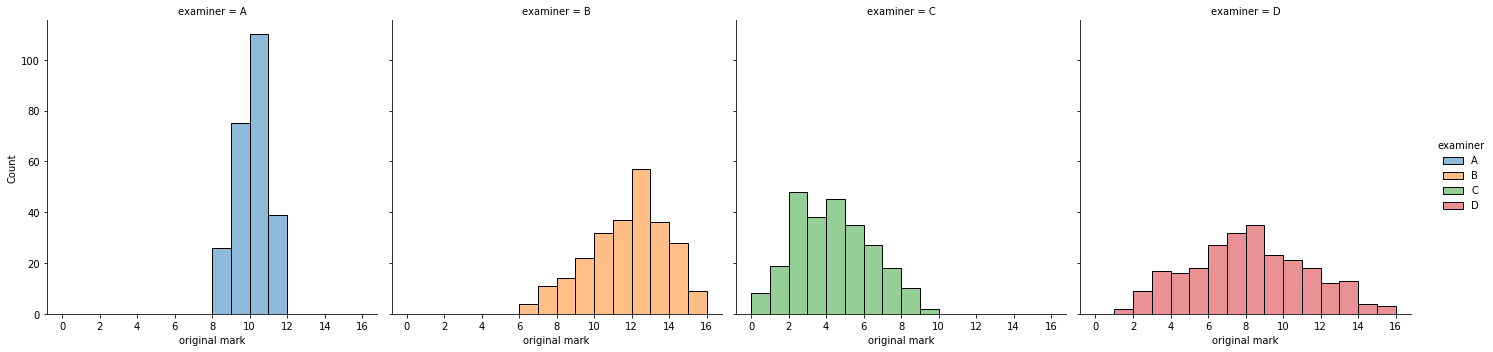

In [3]:
_ = sns.displot(data=df, x='original mark', col='examiner', hue='examiner', bins=np.arange(17))

<br>
<br>

---

## Method

<br>

The method starts here. Use your real data and either:
* adapt it to the format (examiner and marks as columns for each candidate as a row); or
* adapt the code beloww to conform to your data format

<br>

### 1. Characterize each examiner

For each examiner $i \in \lbrace A, B, C, D\rbrace$, we can look up all the marks they gave to the candidates they graded, and report the average $\mu_i$ of these marks and their standard deviation $\sigma_i$. 

<br>

---

**Skip this bit unless you're a nerd**

For purposes of being technically accurate, we say that the average mark $\mu_i$ given by examiner $i$ is their 
_expected_ mark, so $mu_i$ is the expected value of all their given marks, _i.e._ the sample mean: $$\mu_i = \text{E} \left[ X \right]$$ where $X$ is the random variable denoting a candidate's mark $x$ graded by examiner $i$.

Likewise, the square of the standard deviation here is the sample variance, _i.e._ the expected value of the squared differences between the marks and the sample mean:

$$\sigma^2_i = \text{E} \left[ \left( X - \text{E} \left[ X \right] \right)^2 \right]$$

---

<br>


Stricter examiners will likely have a lower given average mark than lenier ones. The standard deviation quantifies how spread out the marks are given by each examiner; so an examiner consistently grading around the same mark will have a smaller $\sigma_i$ value compared to one who doesn't shy away from using the whole range of grades from 0 to 16. 


<br>

In the table below, we compute the average mark and spread of each examiner's graded sample:

In [4]:
examiner_stats = df.groupby('examiner').agg({'original mark':[np.mean, np.std]}).round(2)
examiner_stats

original mark      
                  mean   std
examiner                    
A                10.09  0.80
B                11.72  2.07
C                 4.31  2.06
D                 8.14  3.14

<br>


### 2. Compute the $z$ score

Each student now gets a $z$ score that represents how many standard deviations away their mark $x$ is from the average mark given by their respective examiners. You can compute the $z$-score using the following formula

$$z = \frac{x-\mu_i}{\sigma_i}$$

Note here that the $\left( \mu_i, \sigma_i \right)$ pair is **dependent on the examiner**, and characterize their grading "style". 

The $z$ score therefore accounts for the examiner quality. Candidates can have similar marks yet different $z$ scores if they were graded by different examiners, and _vice versa_.


A $z=0$ means their mark was average relative to their examiners.<br>
A $z=1$ means the candidate's mark is one stardard deviation above their respective examiner's average mark, and they are in the top 16% of the candidates ranked from that specific examiner.<br>
Candidates with $z=2$ are 2 standard deviations above the mean, so in the top 2%.<br>
Likewise, $z$ scores can be negative and reflect how many standard deviations _below_ the average a candidate's mark is relative to their examiner. 

You can play around with this [$z$ score calculator](https://www.calculator.net/z-score-calculator.html?c2z=2&c2p=&c2pg=&c2p0=&c2pin=&c2pout=&calctype=converter&x=Calculate#converter) to get an intuition for the probabilities associated with the $z$ values. 


<br>

We define the $z$ score function that takes in a candidate's mark and which examiner graded them. The function looks up that examiner's average given mark and marks standard deviations given in the look-up table just above.

In [5]:
def get_zscore(mark, examiner):
    
    avg_ex, std_ex = examiner_stats.loc[examiner].values
    zscore = (mark - avg_ex) / std_ex
    
    return zscore


df['zscore'] = df.apply(lambda x: get_zscore(*x[::-1]), axis=1)
df

,examiner,original mark,zscore
0,A,8.7,-1.737500
1,A,10.4,0.387500
2,A,10.1,0.012500
3,A,11.5,1.762500
4,A,10.5,0.512500
...,...,...,...
995,D,7.2,-0.299363
996,D,8.8,0.210191
997,D,10.9,0.878981
998,D,12.7,1.452229


<br>

### 3. Characterize the whole sample

In step one, we reported the average mark and standard deviation broken down by each examiner sample. Now, we want to compute the overall expected mark and sample variance _irrespective_ of the examiner. We'll call these the _population_ mean and standard deviation as a bit of an abuse of language:

In [6]:
population_stats = df['original mark'].agg([np.mean, np.std]).to_frame()
population_stats

,original mark
mean,8.563500
std,3.521195


<br>

### 4. Re-scale the $z$-scores 

Finally, we want to convert back each candidate's $z$ score back to an interpretable mark, corrected for examiner quality. We do this simply by applying the inverse transform of the formula defined above, except this time we use the population mean mark $M$ and standard deviation $S$ given in the table above. A candidate's re-scaled mark $\hat{x}$ given their $z$ score is thus:

$$\hat{x} = z \times S + M$$

We apply this formula to all the candidates' $z$ scores:

In [7]:
avg_pop, std_pop = population_stats.T.values[0]


def get_rescaled_grade(zscore):

    return zscore * std_pop + avg_pop


df['rescaled mark'] = df.zscore.apply(get_rescaled_grade).round(1)
df

,examiner,original mark,zscore,rescaled mark
0,A,8.7,-1.737500,2.4
1,A,10.4,0.387500,9.9
2,A,10.1,0.012500,8.6
3,A,11.5,1.762500,14.8
4,A,10.5,0.512500,10.4
...,...,...,...,...
995,D,7.2,-0.299363,7.5
996,D,8.8,0.210191,9.3
997,D,10.9,0.878981,11.7
998,D,12.7,1.452229,13.7


<br>

### 5. Adjust for out-of-range marks

With the method above, it's possible that the highest rescaled marks exceed 16, and likewise the lowest fall lower than 0. T ensure that isnt the case, we can either:

* clip off the outlying values, so marks below 0 get floored to 0 and marks above 16 get capped at 16.
* re-scale the entire marks again to ensure the lowest est highest marks get mapped to 0 and 16 respectively. This will affect all marks, not just the outlying ones.

<br>

Here, I use the clipping method as it only involves a few exceedents.

In [8]:
df['rescaled mark'].clip(0,16, inplace=True)

<br>

### Outcome

To visualise the difference between the original and rescaled marks, we plot these for all candidates on the $x$ and $y$ axes respectively, and color-encode which examiner graded them. Notice on the following figure that all 4 colored point sprees are aligned in a straight line, although their slopes may differ.

The more an examiner grades in a representative manner to the overall population, the closer to a 1:1 relationship there will be, meaning the correction didn't affect the original marks all that much. Candidates graded by stricter examiners will get a larger "boost" to their final marks, and inversely. Those graded by examiners that grade candidates very narrowly have a steeper line on the graph below, because the of the difference in standard deviation (mark spread) was taken into account

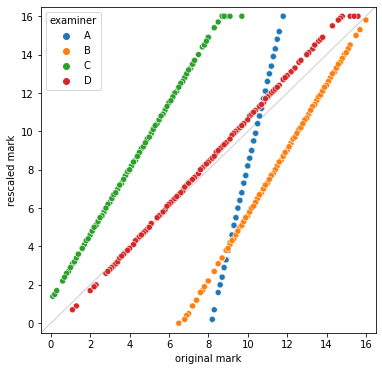

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
_ = ax.plot((-1,17),(-1,17), linewidth=0.75, color='silver', zorder=0)
sns.scatterplot(data=df, x='original mark', y='rescaled mark', hue='examiner', ax=ax, zorder=1)
_ = ax.set_xlim(-0.5,16.5)
_ = ax.set_ylim(-0.5,16.5)

<br>

Here's what the final versus orginal distributions of marks looks like

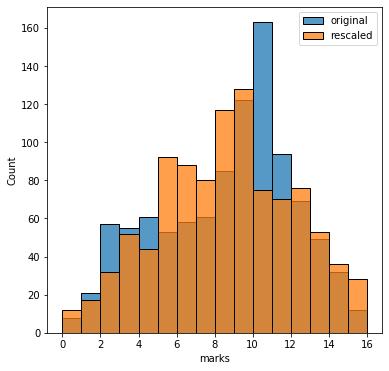

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
sns.histplot(data=df, x='original mark', ax=ax, bins=np.arange(17), label='original')
sns.histplot(data=df, x='rescaled mark', ax=ax, bins=np.arange(17), label='rescaled')
_ = ax.set_xlabel('marks')
_ = ax.legend()